# Data feature augmentation

* Augment data by creating new features as combinations of existing features
* Perform a t-test on experimental data to test for significant differences in performance

# Data

In [14]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt

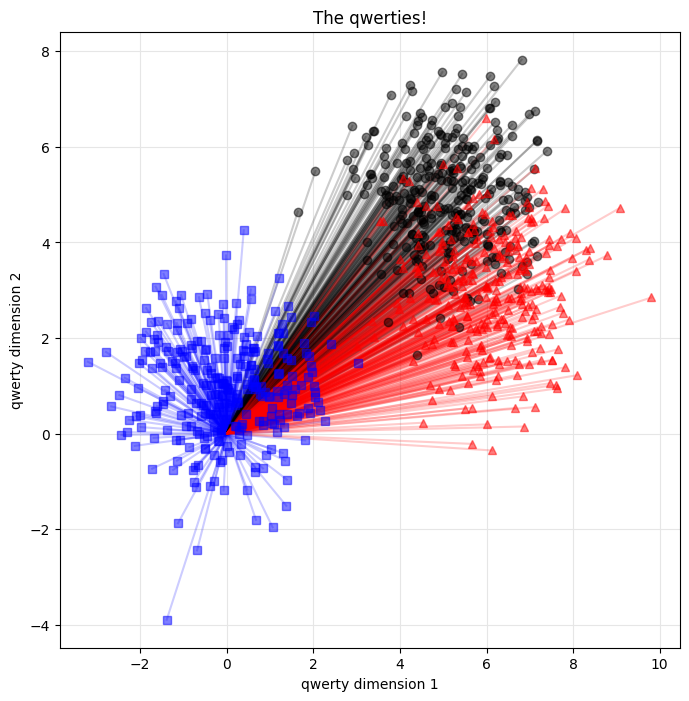

In [17]:
n_per_clust = 300
blur = 1.1

A = [0,1]
B = [5,5]
C = [6,3]

a = [A[0] + np.random.randn(n_per_clust) * blur, A[1] + np.random.randn(n_per_clust) * blur]
b = [B[0] + np.random.randn(n_per_clust) * blur, B[1] + np.random.randn(n_per_clust) * blur]
c = [C[0] + np.random.randn(n_per_clust) * blur, C[1] + np.random.randn(n_per_clust) * blur]

labels = np.hstack(
    (np.zeros(n_per_clust),
     np.ones(n_per_clust),
     np.ones(n_per_clust) + 1)
)
data = np.hstack(
    (a,b,c)
).T

labels = torch.tensor(labels).long()
data = torch.tensor(data).float()

fig = plt.figure(figsize = (8,8))

color = 'bkr'
for i in range(len(data)):
  plt.plot([0, data[i, 0]], [0,data[i,1]], color = color[labels[i]], alpha=.2)

plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels == 0)[0],1], 'bs', alpha = .5)
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels == 1)[0],1], 'ko', alpha = .5)
plt.plot(data[np.where(labels==2)[0], 0], data[np.where(labels == 2)[0],1], 'r^', alpha = .5)

plt.grid(color = [.9,.9,.9])
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

# Adding feature

## Create Feature

We're going to add Euclidean Distance as a new feature

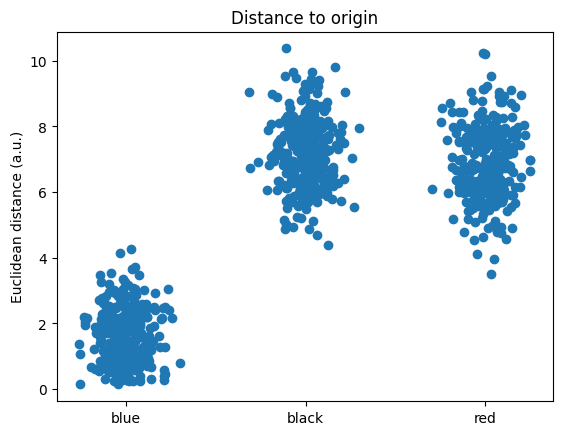

In [18]:
dist2orig = torch.sqrt(data[:,0]**2 + data[:,1]**2)

plt.plot(labels + torch.randn(900)/10, dist2orig, 'o')
plt.xticks([0,1,2], labels = ['blue', 'black', 'red'])
plt.ylabel('Euclidean distance (a.u.)')
plt.title('Distance to origin')
plt.show()

## Add feature to data matrix

Below we see 2 features with X and Y

In [20]:
data

tensor([[-0.5011, -0.3135],
        [-0.0856,  2.7003],
        [-0.1414,  0.0694],
        ...,
        [ 5.5777,  1.9589],
        [ 6.4080,  4.1629],
        [ 6.7847,  2.9376]])

Below we see matrix with added feature

In [19]:
data_aug = torch.cat((data, dist2orig.view(len(data), 1)), axis = 1)
data_aug

tensor([[-0.5011, -0.3135,  0.5911],
        [-0.0856,  2.7003,  2.7017],
        [-0.1414,  0.0694,  0.1575],
        ...,
        [ 5.5777,  1.9589,  5.9116],
        [ 6.4080,  4.1629,  7.6415],
        [ 6.7847,  2.9376,  7.3933]])

# Split

In [62]:
def create_data(data):
  train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)

  train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
  test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)

  batch_size = 16
  train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
  test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

  return train_dataloader, test_dataloader

For Not Augmented Data

In [63]:
train_dataloader, test_dataloader = create_data(data)
train_dataloader.dataset.tensors[0].shape

torch.Size([720, 2])

For Augmented Data

In [64]:
train_dataloader, test_dataloader = create_data(data_aug)
train_dataloader.dataset.tensors[0].shape

torch.Size([720, 3])

# Model

## Arch

In [65]:
class ModelArch(nn.Module):
  def __init__(self, aug):
    super().__init__()

    # input
    if aug:
      self.input = nn.Linear(3, 32)
    else:
      self.input = nn.Linear(2, 32)

    # hidden
    self.fc1 = nn.Linear(32, 64)
    self.fc2 = nn.Linear(64, 32)

    # output
    self.output = nn.Linear(32, 3)

  # forward pass
  def forward(self, x):

    x = self.input(x)
    x = F.relu(x)

    # hidden layer 1
    x = self.fc1(x)   # weighted combination
    x = F.relu(x)     # activation function

    # hidden layer 2
    x = self.fc2(x)# weighted combination
    x = F.relu(x)

    x = self.output(x)

    return x

## Setup

In [66]:
def ModelSetup(aug):
  ann = ModelArch(aug)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ann.parameters(), lr = 1e-3)

  return ann, loss_fn, optimizer

In [68]:
train_dataloader, test_dataloader = create_data(data_aug)

ann, loss_fn, optimizer = ModelSetup(aug=True)
X, y = next(iter(train_dataloader))
temp_data = torch.randn(10, 3)
temp_y_hat = ann(X)
temp_y_hat

tensor([[ 0.0816,  0.0877,  0.0979],
        [ 0.0618,  0.5136, -0.1125],
        [ 0.0879,  0.0689,  0.0920],
        [ 0.0949,  0.0895,  0.0692],
        [ 0.0571,  0.6156, -0.1535],
        [ 0.0591,  0.5733, -0.1353],
        [ 0.0585,  0.5898, -0.1429],
        [ 0.0937,  0.0905,  0.1253],
        [ 0.0409,  0.8036, -0.2319],
        [ 0.0652,  0.7213, -0.1736],
        [ 0.0547,  0.5208, -0.1283],
        [ 0.0568,  0.6165, -0.1532],
        [ 0.0885,  0.0887,  0.1159],
        [ 0.0574,  0.7629, -0.1971],
        [ 0.0653,  0.5337, -0.1171],
        [ 0.0642,  0.4527, -0.0880]], grad_fn=<AddmmBackward0>)

## Train

In [70]:
def ModelTrain(epochs, aug, train_dataloder, test_dataloder, verbose = True):
  ann, loss_fn, optimizer = ModelSetup(aug)

  losses = torch.zeros(epochs)

  train_accs = torch.zeros(epochs)
  test_accs = torch.zeros(epochs)

  for epoch in range(epochs):
    ann.train()

    batch_accs = torch.zeros(len(train_dataloader))
    batch_losses = torch.zeros(len(train_dataloader))

    for batch, (X_train, y_train) in enumerate(train_dataloader):

      batch_y_hat = ann(X_train)

      loss = loss_fn(batch_y_hat, y_train)
      batch_losses[batch] = loss

      acc = 100 * torch.mean(
          (torch.argmax(batch_y_hat, axis = 1) == y_train ).float()
      )
      batch_accs[batch] = acc

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    losses[epoch] = torch.mean(batch_losses)
    train_accs[epoch] = torch.mean(batch_accs)

    # test accuracy
    ann.eval()
    X_test, y_test = next(iter(test_dataloader))
    with torch.no_grad():
      test_y_hat = ann(X_test)
    test_acc = 100 * torch.mean(
        ( torch.argmax(test_y_hat, axis = 1) == y_test ).float()
    )
    test_accs[epoch] = test_acc

    if epoch % 10 == 0 and verbose:
      print(f'Epoch {epoch} | Loss: {torch.mean(batch_losses):2f} | Train Acc: {torch.mean(batch_accs):2f} | Test Acc: {test_acc:2f}')

  return train_accs, test_accs, losses

In [71]:
train_dataloader, test_dataloader = create_data(data)
train_accs, test_accs, losses = ModelTrain(50, False, train_dataloader, test_dataloader, verbose= True)

Epoch 0 | Loss: 1.013607 | Train Acc: 60.972221 | Test Acc: 51.666664
Epoch 10 | Loss: 0.859124 | Train Acc: 68.750000 | Test Acc: 70.000000
Epoch 20 | Loss: 0.803558 | Train Acc: 80.277779 | Test Acc: 75.555557
Epoch 30 | Loss: 0.750748 | Train Acc: 82.222221 | Test Acc: 80.000000
Epoch 40 | Loss: 0.697138 | Train Acc: 84.861115 | Test Acc: 81.111107


In [72]:
train_dataloader, test_dataloader = create_data(data_aug)
train_accs, test_accs, losses = ModelTrain(50, True, train_dataloader, test_dataloader, verbose= True)

Epoch 0 | Loss: 1.049899 | Train Acc: 41.250000 | Test Acc: 49.444443
Epoch 10 | Loss: 0.915126 | Train Acc: 56.805557 | Test Acc: 53.888885
Epoch 20 | Loss: 0.827264 | Train Acc: 70.555557 | Test Acc: 70.555557
Epoch 30 | Loss: 0.737186 | Train Acc: 79.305557 | Test Acc: 79.444443
Epoch 40 | Loss: 0.643355 | Train Acc: 82.916664 | Test Acc: 82.222221


# Experiment

In [85]:
epochs = 1000

aug_results = torch.zeros((epochs, 3))
org_results = torch.zeros((epochs, 3))

train_dataloader, test_dataloader = create_data(data)
train_accs, test_accs, losses = ModelTrain(epochs, False, train_dataloader, test_dataloader, verbose= True)
org_results[:,0] = train_accs
org_results[:,1] = test_accs
org_results[:,2] = losses

train_dataloader, test_dataloader = create_data(data_aug)
train_accs, test_accs, losses = ModelTrain(epochs, True, train_dataloader, test_dataloader, verbose= True)
aug_results[:,0] = train_accs
aug_results[:,1] = test_accs
aug_results[:,2] = losses

Epoch 0 | Loss: 1.041330 | Train Acc: 60.555557 | Test Acc: 63.888889
Epoch 10 | Loss: 0.847026 | Train Acc: 76.527779 | Test Acc: 77.222221
Epoch 20 | Loss: 0.767478 | Train Acc: 84.444443 | Test Acc: 84.444443
Epoch 30 | Loss: 0.684730 | Train Acc: 87.222221 | Test Acc: 85.000000
Epoch 40 | Loss: 0.597503 | Train Acc: 88.750000 | Test Acc: 84.444443
Epoch 50 | Loss: 0.517064 | Train Acc: 89.027779 | Test Acc: 85.555557
Epoch 60 | Loss: 0.452203 | Train Acc: 88.750000 | Test Acc: 85.555557
Epoch 70 | Loss: 0.404399 | Train Acc: 88.472221 | Test Acc: 85.555557
Epoch 80 | Loss: 0.371226 | Train Acc: 88.333336 | Test Acc: 86.111107
Epoch 90 | Loss: 0.346151 | Train Acc: 88.750000 | Test Acc: 85.555557
Epoch 100 | Loss: 0.327755 | Train Acc: 89.027779 | Test Acc: 87.222221
Epoch 110 | Loss: 0.314000 | Train Acc: 88.888885 | Test Acc: 86.666664
Epoch 120 | Loss: 0.303698 | Train Acc: 88.611115 | Test Acc: 86.666664
Epoch 130 | Loss: 0.295210 | Train Acc: 89.027779 | Test Acc: 85.555557
Epo

# Plot

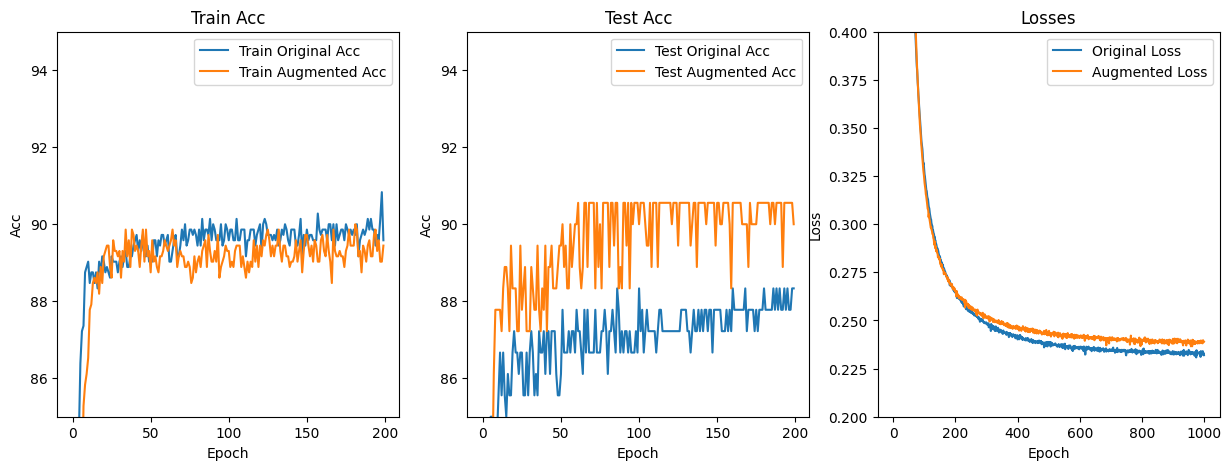

In [96]:
fig, ax = plt.subplots(1,3,figsize = (15, 5))

gap = 5

ax[0].plot(org_results[:,0][::gap].detach(), label = 'Train Original Acc')
ax[0].plot(aug_results[:,0][::gap].detach(), label = 'Train Augmented Acc')
ax[0].legend()
ax[0].set_title('Train Acc')
ax[0].set_ylabel('Acc')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim([85,95])

ax[1].plot(org_results[:,1][::gap].detach(), label = 'Test Original Acc')
ax[1].plot(aug_results[:,1][::gap].detach(), label = 'Test Augmented Acc')
ax[1].legend()
ax[1].set_title('Test Acc')
ax[1].set_ylabel('Acc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylim([85,95])

ax[2].plot(org_results[:,2].detach(), label = 'Original Loss')
ax[2].plot(aug_results[:,2].detach(), label = 'Augmented Loss')
ax[2].legend()
ax[2].set_title('Losses')
ax[2].set_ylabel('Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylim([0.2,0.4])

plt.show()

# Conclusion

The training accuracies remain comparable between the original and augmented datasets, with a minor advantage for the original data. However, the test accuracy exhibits a clear improvement when augmentation is applied. This indicates that the added Euclidean distance feature enhanced generalization and mitigated overfitting.

That means Euclidean Distance wasn't a linear combination of X and Y (other features) if it would be we wouldn't benefit from additional feature.